# La vitrine de QQDN

## Les imports

In [1]:
%reset -f

In [2]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE.git
    %ls
else:
    print("on n'est pas sur colab")

import popup_lib.popup as pop

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 133 (delta 58), reused 110 (delta 35), pack-reused 0
Receiving objects: 100% (133/133), 2.78 MiB | 29.64 MiB/s, done.
Resolving deltas: 100% (58/58), done.
From https://github.com/vincentvigon/RECHERCHE
 * branch            HEAD       -> FETCH_HEAD
 ddqn_lib/   Euler/  'Icon'$'\r'   popup_lib/   sample_data/   toto.py*
Popup loaded!


In [3]:
%ls

 ddqn_lib/   Euler/  'Icon'$'\r'   popup_lib/   sample_data/   toto.py*


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf
import time

In [5]:
import ddqn_lib.ddqn as dd

## Un exemple en grande dimension

### L'environnement

In [6]:
DIM=300
SIGMA_NOISE=3
DRIFT=1e-1

def random_sinus_sum(dim):
    res=np.zeros([dim])
    x=np.linspace(0,2*np.pi,dim)
    for i in range(1,10):
        res+=np.random.uniform(-0.2,0.2)*np.sin(i*x)
    return res


In [7]:
"""Il faut bien régler les paramètres sigma et initial_size
 pour que l'on ne gagne pas à chaque coup: utiliser le test_zero_action() pour vérifier """
class Sinus_Env(dd.Abstract_Environment):

    def __init__(self, dim=DIM, sigma_noise=SIGMA_NOISE, initial_size=5, reward_when_win=100):
        self.dim=dim
        self.sigma_noise = sigma_noise
        self.initial_size=initial_size
        self.reward_when_win=reward_when_win
        self.value=np.zeros([dim])
        self.count = 0
        self.render_is_active=False

    def get_dim_state(self) -> int:
        return self.dim

    def get_dim_action(self) -> int:
        return self.dim

    def reset(self)->np.ndarray:
        self.value= random_sinus_sum(self.dim)*self.initial_size
        self.count=0
        return self.value

    def step(self, action):
        assert action.shape==(self.dim,), f"action must have the dimension {self.dim} but shape is {action.shape} "
        self.value+= action + self.sigma_noise * random_sinus_sum(self.dim)+DRIFT
        self.count+=1

        terminal_bad = False
        terminal_good = False

        too_big=np.sum(self.value>20)
        too_small=np.sum(self.value<-20)
        inside = too_big+too_small ==0
        if not inside:
            terminal_bad = True

        if terminal_bad:
            reward = -self.reward_when_win
        else:
            reward = 1

        # on gagne si la fonction reste 100 fois dans les bornes
        if self.count > 100:
            terminal_good = True
            reward = self.reward_when_win

        terminal = terminal_bad or terminal_good
        if terminal:
            self.reset()  # la position est réinitialiser
        if self.render_is_active:
            self._record_for_render()

        return self.value, reward, terminal


    def start_render(self):
        self.render_is_active=True
        self.curves=[]
        self.current_render_stop=0

    def do_render(self):
        x=np.linspace(0,2*np.pi,self.dim)
        self.render_is_active=False
        nb=len(self.curves)
        for i,curve in enumerate(self.curves):
            if i==0:
                alpha=1
                color="r"
            else:
                alpha = i / nb
                color="k"
            plt.plot(x,curve,color,alpha=alpha)
        plt.show()

    def _record_for_render(self):
        self.curves.append(self.value.copy())

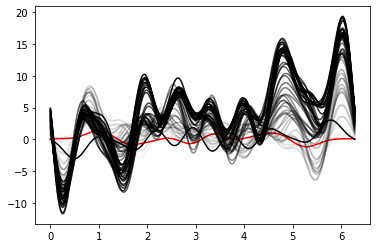

reward:-100, count:50


In [8]:
def test_env_graph():
    dim=300
    env=Sinus_Env(dim)
    zero_action=np.zeros([dim])
    done=False
    env.start_render()
    r=0
    count=0
    while not done:
        count+=1
        s_,r,done=env.step(zero_action)
    env.do_render()
    print(f"reward:{r}, count:{count}")
    
test_env_graph()

### Une baseline: la politique constante

In [9]:
def evaluate_policy(env:Sinus_Env, policy):
    rewards=[]
    ep_lengths=[]
    nb_win=0
    nb_test=40
    for _ in range(nb_test):
        r = None
        ep_length = 0
        cum_reward=0
        done=False
        s=env.reset()
        while not done:
            ep_length+=1
            s,r,done=env.step(policy(s))
            cum_reward+=r
        if r==env.reward_when_win:
            nb_win+=1
        ep_lengths.append(ep_length)
        rewards.append(cum_reward)

    print(f"win:{nb_win/nb_test} cum_rewards:{np.mean(rewards)}, episode length:{np.mean(ep_lengths)}")

def test_constant_policy():
    env=Sinus_Env(DIM)
    policy=lambda state:np.zeros([env.dim])-DRIFT
    evaluate_policy(env, policy)
test_constant_policy()


win:0.8 cum_rewards:155.45, episode length:96.45


## Les modèles

In [10]:
def layer_triple(y):
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    y = tf.keras.layers.Conv1D(6, 5, activation="relu", padding="same")(y)
    return y

def actor_maker_fn():
    input_state=tf.keras.layers.Input([DIM,1])
    y=layer_triple(input_state)
    output_action=tf.keras.layers.Conv1D(1,5,padding="same")(y)
    #il faut une action de taille comparable au bruit pour pouvoir le compenser
    output_action=output_action[:,:,0]*SIGMA_NOISE
    return tf.keras.Model(inputs=input_state,outputs=output_action)

def critic_maker_fn():
    input_state = tf.keras.layers.Input([DIM,1])
    input_action = tf.keras.layers.Input([DIM,1])
    y_state = layer_triple(input_state)
    y_action = layer_triple(input_action)
    y=tf.keras.layers.Concatenate()([y_state,y_action])
    y=layer_triple(y)
    output_critic = tf.keras.layers.Conv1D(1,5,padding="same")(y)
    output_critic = output_critic[:,:,0]
    return tf.keras.Model(inputs=[input_state,input_action], outputs=output_critic)

def test_models():
    batch_size=3
    input_action=np.random.normal(size=[batch_size,DIM,1])
    input_critic = np.random.normal(size=[batch_size,DIM,1])
    model_actor=actor_maker_fn()
    model_critic=critic_maker_fn()
    res_actor=model_actor(input_action).numpy()
    print(f"actor result shape{res_actor.shape} , sdt:{np.std(res_actor.flatten())}")
    res_critic=model_critic([input_action,input_critic]).numpy()
    print(f"actor result shape{res_critic.shape} , sdt:{np.std(res_critic.flatten())}")

test_models()

actor result shape(3, 300) , sdt:0.41481226682662964
actor result shape(3, 300) , sdt:0.05723951756954193


## Entrainement d'un seul agent (sans popup)

In [11]:
env = Sinus_Env()

agent=dd.Agent_ddqn(env, actor_maker_fn, critic_maker_fn,
                          perturb_action_sigma=10**np.random.uniform(-3,-1),
                          min_seconds_before_score=2)

scores=[]
for _ in range(10):
    score=agent.optimize_and_return_score()
    scores.append(score)
    print(f"score:{score}")

print(scores)

score:-86.0
score:-73.5
score:200.0
score:200.0
score:-11.0
score:200.0
score:200.0
score:200.0
score:-27.0
score:200.0
[-86.0, -73.5, 200.0, 200.0, -11.0, 200.0, 200.0, 200.0, -27.0, 200.0]


## Entrainement d'une famille (avec popup)

In [12]:
def make_family():
    env = Sinus_Env()
    print("The zero policy gives:")
    evaluate_policy(env, lambda state: np.zeros([env.dim]))

    env = Sinus_Env()
    print("The zero policy gives:")
    evaluate_policy(env, lambda state: np.zeros([env.dim]))


    """ décomenter cette partie pour ajouter une méthode perturbant les famparams à
    chaque mutation"""
    #
    # def set_and_perturb_famparams(agent:dd.Agent_ddqn,famparams,period_coung:int):
    #     famparams["lr"]*=np.random.uniform(0.7,1.7)
    #     famparams["perturb_action_sigma"]*=np.random.uniform(0.7,1.7)
    #     gamma=np.clip(famparams["gamma"]*np.random.uniform(0.9,1.1),0.5,0.999)
    #     famparams["gamma"]=gamma
    #     agent.famparams=famparams

    #dd.Agent_ddqn.set_and_perturb_famparams=set_and_perturb_famparams

    agents = [dd.Agent_ddqn(env, actor_maker_fn, critic_maker_fn,
                          perturb_action_sigma=10**np.random.uniform(-3,-1),
                          min_seconds_before_score=2)
              for _ in range(5)]

    family_trainer=pop.Family_trainer(agents,"15 seconds")

    return family_trainer

In [13]:
family_trainer=make_family()

The zero policy gives:
win:0.05 cum_rewards:-19.75, episode length:71.25
The zero policy gives:
win:0.05 cum_rewards:-19.8, episode length:71.2


In [14]:
for _ in range(15):
    family_trainer.period()


fam_1,échauffement a↗-94.4b↗-90.0c↗-94.5d↗-85.5e↗-95.5
fam_1,period:1 a↗-70.0b↗-63.0c↗-78.5__a↗-52.0b↗-40.0, mutations:e⇇d|
fam_1,period:2 c↗-55.0d↗-47.0e↗7.3333a↗-34.0, mutations:c⇇c|
fam_1,period:3 _c↗-31.0_, mutations:d⇇b|
fam_1,period:4 e↗200.0__, mutations:d⇇b⇇d|
fam_1,period:5 _d↗-39.0_a↗-28.0, mutations:b⇇b|
fam_1,period:6 ____, mutations:b⇇b⇇a|
fam_1,period:7 _b↗-34.0_, mutations:d⇇b⇇d⇇c|
fam_1,period:8 d↗-34.0_a↗-12.0, mutations:b⇇b⇇a⇇e|
fam_1,period:9 b↗-2.0__, mutations:d⇇b⇇d⇇c⇇c|
fam_1,period:10 __b↗200.0_, mutations:d⇇b⇇d⇇c⇇c⇇b|
fam_1,period:11 d↗-7.0_a↗-9.0, mutations:c⇇c⇇a|
fam_1,period:12 __, mutations:c⇇c⇇a⇇c|
fam_1,period:13 ___, mutations:c⇇c⇇a⇇c⇇d|
fam_1,period:14 _c↗200.0d↗-2.0, mutations:a⇇b|

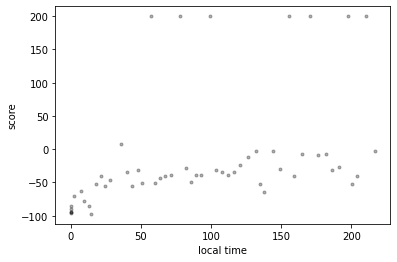

In [15]:
family_trainer.plot_metric("score")

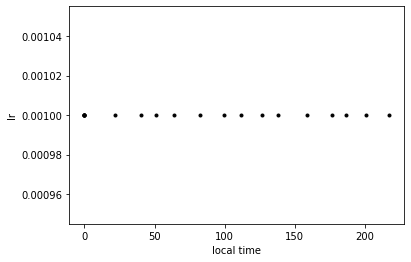

In [16]:
family_trainer.plot_metric("lr")

### Analysons le meilleurs agent

In [17]:
best_agent=family_trainer.get_best_agent()

In [18]:
sinus_env=Sinus_Env()

In [19]:
evaluate_policy(sinus_env,lambda state:best_agent.policy(state,val_mode=True))

win:0.6 cum_rewards:111.375, episode length:92.375


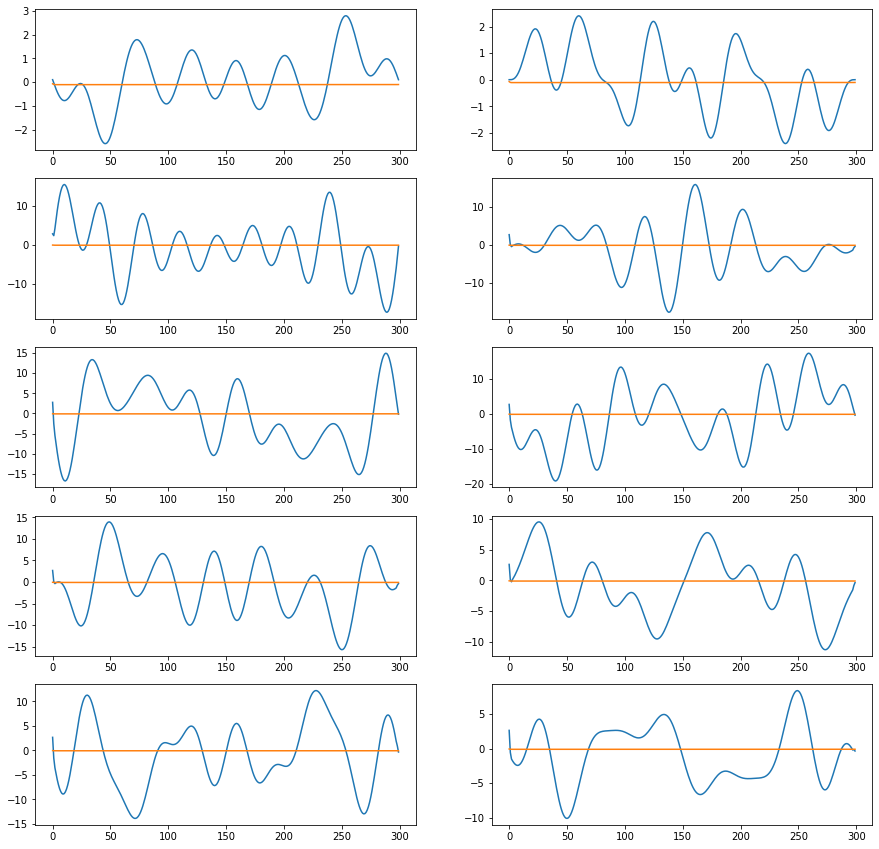

In [20]:
states=[]
action=np.zeros(DIM)
actions=[]
for i in range(1000):
    state,_,_=sinus_env.step(action)
    action=best_agent.policy(state,True)
    if i%100==0:
        states.append(state)
        actions.append(action)

fig,axs=plt.subplots(5,2,figsize=(15,15))
axs=axs.flatten()
x=range(DIM)
for i,ax in enumerate(axs):
    ax.plot(x,states[i])
    ax.plot(x,actions[i])

Si le `DRIFT` est positif, il faudrait que l'action en moyenne soit négative: 

In [21]:
np.mean(actions),DRIFT

(-0.10907259, 0.1)